In [11]:

import mne


import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
# import eelbrain as eel

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert
from scipy.stats import pearsonr, wilcoxon, ttest_ind, ttest_rel, ttest_1samp
from scipy.stats.mstats import winsorize
from collections import Counter

import sys
sys.path.append('../../utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *
from readfiles_utils import *

import pickle
import os

In [12]:
eeg_dir = '../../data_preprocessed_15Hz'
sv_dir = './sv'
mTRF_path = f'./trained_models_forward'


times = create_erp_times(-0.5,0.5, 128)


## Subjects and parameters

In [13]:

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects
#subjects_to_process = ['05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
subjects_to_process = ['06']
#subjects_to_process =['01', '04']

n_subs = len(subjects_to_process)
print('processing subjects:', subjects_to_process)

periods = ['pre']
#features = 'AM' #AM or onsets

overwrite = False
n_segments = 10
fs = 128
tmin, tmax =-0.5, 0.5  # range of time lag
regularization = 0.1



processing subjects: ['06']


## Train forward TRF model

In [14]:
def shuffle_nonzeros(arr):
    """ 
    Shuffles values of nonzero values in sparse support vector
    Nonzero values are found in the same indices as in original array
    arr: array to be shuffled
    returns shuffled_arr
    """
    nonzero_idx = np.where(arr != 0)
    nonzero_arr = arr[nonzero_idx].copy()
    np.random.shuffle(nonzero_arr)
    
    shuffled_arr = np.zeros_like(arr)
    shuffled_arr[nonzero_idx] = nonzero_arr
    return shuffled_arr

In [15]:
save = True
shuffle = True

for subject in subjects_to_process:
    print(f'processing subject {subject}')
    for period in periods:

       
        eeg_path = os.path.join(eeg_dir, f'{subject}/eeg_error_{period}_{subject}.mat')
        
        data = loadmat(eeg_path)
        eeg = data['trial_data']

        

        #error events are already pre-extracted and sorted by first or others so sv can be customized to reflect surprisal
        sv_data = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))


        #for sv_type in svs:
        svs = [x for x in sv_data.keys() if not x.startswith("__")]
        svs = ['onsets', 'firsts']
        for sv_type in svs:
            sv = sv_data[sv_type][0] #take 0 index because it's shaped (1, n_timepoints)

            #trim sv to size (for participants with recordings less than 10 mins)
            if eeg.shape[1] != sv.shape[0]:
                sv = sv[0:eeg.shape[1]]

            if shuffle:
                sv_name = sv_type+'_shuf'

                if sv_type == 'onsets':
                    np.random.shuffle(sv)
                else:
                    sv = shuffle_nonzeros(sv)
            else:
                sv_name = sv_type

            
            eeg_segments = segment(eeg.T, n_segments)
            eeg_segments_norm = normalize_responses(eeg_segments)
            sv_segments = segment(sv, n_segments) 

            #train model for each sv
            fwd_trf = TRF(direction = 1)
            fwd_trf.train(sv_segments, eeg_segments_norm, fs, tmin, tmax, regularization = regularization)

            #save model
            if save: 
                if not os.path.exists(mTRF_path):
                    os.mkdir(mTRF_path)
                fwd_trf.save(os.path.join(mTRF_path, f'fTRF_error_{sv_name}_{subject}_{period}.pkl'))

            

processing subject 06


In [16]:
print(sv_segments.shape)

AttributeError: 'list' object has no attribute 'shape'

## Plot individual subject kernels

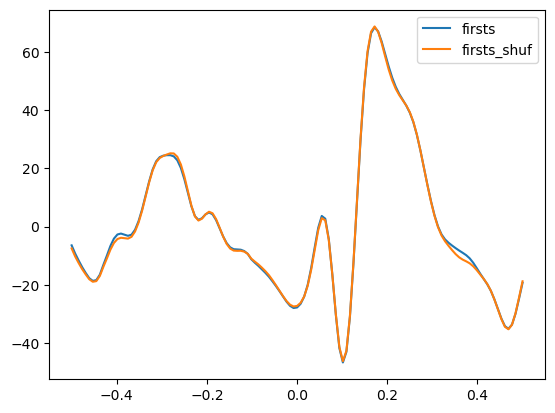

In [339]:
#individual subject data

ch_to_plot = ['FCz']
ch_idx = ch_index(ch_to_plot)
sub = '01'


#for sv_type in svs:
for sv_type in ['firsts', 'firsts_shuf']:
    mtrf_trained = load_pickle(f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/trained_models_forward/fTRF_error_{sv_type}_{sub}_pre.pkl')
    mtrf_weights = mtrf_trained.weights[0]
    mtrf_weights_ch = mtrf_weights[:, ch_idx]

    plt.plot(times, mtrf_weights_ch, label = sv_type)

    


plt.legend()

## Plot group means

In [ ]:
ch_to_plot = ['FCz']

In [341]:
#prepare dataframe, columns = different kernels
weight_data = pd.DataFrame()
for sub in subjects_to_process:

    sv_data = pd.DataFrame({
        'subject':[sub],
        })
    for sv_type in ['onsets', 'firsts', 'firsts_shuf', 'onsets_shuf']:

        # Load subject-specific model
        mtrf_trained = load_pickle(f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/trained_models_forward/fTRF_error_{sv_type}_{sub}_pre.pkl')
        mtrf_weights = mtrf_trained.weights[0]
        
        sv_data[sv_type] = [mtrf_weights]
        
    weight_data= pd.concat([weight_data, sv_data], ignore_index=True)


In [352]:
#find diffs onset vs other svs
weight_data['firsts-onsets'] = weight_data['firsts'] - weight_data['onsets']

# weight_data['onsets_sur-onsets'] = weight_data['onsets_sur'] - weight_data['onsets'] #decaying onsets vs just onsets
weight_data['firsts-firsts_shuf'] = weight_data['firsts'] - weight_data['firsts_shuf'] #firsts vs shuffled firsts
#weight_data['onsets-onsets_shuf'] = weight_data['onsets'] - weight_data['onsets_shuf'] #firsts vs shuffled firsts


# #extract differences
osur_vs_o = np.stack(weight_data['firsts-firsts_shuf'].values)
f_vs_o = np.stack(weight_data['firsts-onsets'].values)

In [353]:
def compute_mean_sem(data, axis=0, ch_idx=None):
    """
    Compute the mean and SEM for a given dataset.
    
    Parameters:
    - data (np.ndarray): Input data array.
    - axis (int): Axis along which to compute the mean/SEM.
    - ch_idx (int or None): If an index is provided, return only that channel. 
                            If None, return all channels.
    
    Returns:
    - mean (np.ndarray): Mean of the data.
    - sem (np.ndarray): SEM of the data.
    """
    mean = np.mean(data, axis=axis)
    sem = np.std(data, axis=axis, ddof=1) / np.sqrt(data.shape[axis])
    
    if ch_idx is not None:
        mean = mean[..., ch_idx].squeeze()
        sem = sem[..., ch_idx].squeeze()
    
    return mean, sem

In [354]:
f_vs_o_ave_ch, f_vs_o_sem_ch = compute_mean_sem(f_vs_o, axis = 0, ch_idx = ch_idx)
osur_vs_o_ave_ch, osur_vs_o_sem_ch = compute_mean_sem(osur_vs_o, axis = 0, ch_idx = ch_idx)

In [355]:
# #extract differences
# osur_vs_o = np.stack(weight_data['onsets_sur-onsets'].values)
# f_vs_o = np.stack(weight_data['firsts-onsets'].values)

# #calculate mean
# osur_vs_o_ave = np.mean(osur_vs_o, axis = 0)
# f_vs_o_ave = np.mean(f_vs_o, axis = 0)

# #calculate sem
# osur_vs_o_sem = np.std(osur_vs_o, axis=0, ddof=1) / np.sqrt(osur_vs_o.shape[0])
# f_vs_o_sem = np.std(f_vs_o, axis=0, ddof=1) / np.sqrt(f_vs_o.shape[0])

# #extract channels of interest
# f_vs_o_ave_ch = f_vs_o_ave[:, ch_idx].squeeze()
# osur_vs_o_ave_ch = osur_vs_o_ave[:, ch_idx].squeeze()

# osur_vs_o_sem_ch = osur_vs_o_sem[:, ch_idx].squeeze()
# f_vs_o_sem_ch = f_vs_o_sem[:, ch_idx].squeeze()


In [356]:
def wilcoxon_array(data, axis, fdr = True):
    """
    data: 2d, one dimension is time and the other is subject
    """
    

    w, p = wilcoxon(data, axis = axis)
    p = p.squeeze()

    if fdr:
        _,p = fdrcorrection(p)

    return w, p

def find_sig_times(p, times):
    """ 
    Finds the times at which the test is significant
    p: p values of shape n_timepoints,
    times: vector of timepoints
    """
    assert p.shape == times.shape, 'array p must be same shape as times'
    sig_idx = np.where(p<0.05)

    return times[sig_idx]

In [357]:
w_fo, p_fo = wilcoxon_array(f_vs_o[:,:, ch_idx], axis = 0, fdr = False)
fo_sig_times = find_sig_times(p_fo, times)

w_oo, p_oo = wilcoxon_array(osur_vs_o[:,:, ch_idx], axis = 0, fdr = False)
oo_sig_times = find_sig_times(p_oo, times)

In [358]:
p_oo

array([0.76602936, 0.57984161, 0.46829224, 0.41711426, 0.5508728 ,
       0.5508728 , 0.5508728 , 0.76602936, 1.        , 0.63969421,
       0.41711426, 0.57984161, 0.70188141, 0.79870605, 0.89857483,
       0.76602936, 0.6705246 , 0.60945892, 0.52261353, 0.44229889,
       0.39273834, 0.32472992, 0.32472992, 0.32472992, 0.5508728 ,
       0.76602936, 0.96611786, 0.86504364, 0.7337265 , 0.7337265 ,
       0.76602936, 0.79870605, 0.86504364, 0.93228149, 0.60945892,
       0.28372955, 0.11870575, 0.08142853, 0.12973785, 0.21214294,
       0.46829224, 0.70188141, 0.96611786, 1.        , 0.6705246 ,
       0.44229889, 0.26452637, 0.36921692, 0.6705246 , 1.        ,
       1.        , 0.89857483, 1.        , 0.93228149, 0.96611786,
       0.96611786, 0.60945892, 0.46829224, 0.83172607, 0.76602936,
       0.6705246 , 0.36921692, 0.57984161, 0.57984161, 0.46829224,
       0.49507904, 0.6705246 , 1.        , 0.79870605, 0.76602936,
       1.        , 0.63969421, 0.21214294, 0.07368469, 0.01387

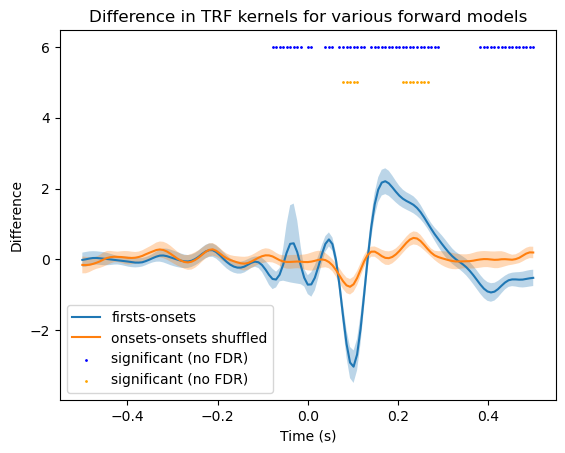

In [364]:

plt.plot(times,f_vs_o_ave_ch, label = 'firsts-onsets')
plt.plot(times,osur_vs_o_ave_ch, label = 'onsets-onsets shuffled')

#Add shaded SEM regions
plt.fill_between(times, 
                 f_vs_o_ave_ch - f_vs_o_sem_ch, 
                 f_vs_o_ave_ch + f_vs_o_sem_ch, 
                 alpha=0.3)

plt.fill_between(times, 
                 osur_vs_o_ave_ch - osur_vs_o_sem_ch, 
                 osur_vs_o_ave_ch + osur_vs_o_sem_ch, 
                alpha=0.3)

plt.scatter(fo_sig_times, np.full_like(fo_sig_times, 6), s=1, label="significant (no FDR)", color = 'blue')  
plt.scatter(oo_sig_times, np.full_like(oo_sig_times, 5), s=1, label="significant (no FDR)", color = 'orange')  


plt.xlabel('Time (s)')
plt.ylabel('Difference')
plt.title('Difference in TRF kernels for various forward models')
plt.legend()

In [360]:
# #plot mean and SEM over subjects

# for sv_type in svs:
#     all_subjects_data = []  # Store data from all subjects

#     for sub in subjects:
#         # Load subject-specific model
#         mtrf_trained = load_pickle(f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/trained_models_forward/fTRF_error_{sv_type}_{sub}_pre.pkl')
#         mtrf_weights = mtrf_trained.weights[0]
#         mtrf_weights_ch = mtrf_weights[:, ch_idx].flatten()  # Ensure it's 1D

#         all_subjects_data.append(mtrf_weights_ch)

#     # Convert list to NumPy array: Shape (n_subjects, n_timepoints)
#     all_subjects_data = np.array(all_subjects_data)

#     # Compute mean and SEM across subjects (axis=0 → across subjects)
#     mean_values = np.mean(all_subjects_data, axis=0)
#     sem_values = sem(all_subjects_data, axis=0)

#     # Plot mean
#     plt.plot(times, mean_values, label=sv_type)

#     # Plot SEM as shaded region
#     plt.fill_between(times, mean_values - sem_values, mean_values + sem_values, alpha=0.3)


In [361]:
# fig, axes = plt.subplots(5,1, sharex = True)
# for i, sv_type in enumerate(svs):
#     axes[i].plot(sv_data[sv_type][0][0:5000])
#     axes[i].set_title(sv_type)
# plt.tight_layout()
